In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Conv2DTranspose
from keras.optimizers import Adam
from ipywidgets import interact
import ipywidgets as widgets
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras

In [19]:
ls

'#2 DL Model Capstone 2 HED.ipynb'
'#2 DL Model Capstone 2.ipynb'
'#2 DL Model Capstone 2 v2.ipynb'
'Step 1. Data Wrangling'/
 ThinSectionAE-model-01-0.0860-0.1338.hdf5
 ThinSectionAE-model-01-0.0862-0.0460.hdf5
 ThinSectionAE-model-01-0.0880-0.1034.hdf5
 ThinSectionAE-model-01-0.0899-0.0723.hdf5
 ThinSectionAE-model-01-0.0917-0.1795.hdf5
 ThinSectionAE-model-01-0.0925-0.0549.hdf5
 ThinSectionAE-model-01-0.0934-0.0980.hdf5
 ThinSectionAE-model-01-0.0959-0.3251.hdf5
 ThinSectionAE-model-01-0.0981-0.0445.hdf5
 ThinSectionAE-model-01-0.1068-0.0471.hdf5
 ThinSectionAE-model-01-0.1071-0.0381.hdf5
 ThinSectionAE-model-01-0.2616-0.2548.hdf5
 ThinSectionAE-model-01-15.0691-28.5317.hdf5
 ThinSectionAE-model-01-20.2686-38.0556.hdf5
 ThinSectionAE-model-01-21.8554-39.5578.hdf5
 ThinSectionAE-model-01-32.1437-35.5549.hdf5
 ThinSectionAE-model-01-71.4548-167.3846.hdf5
 ThinSectionAE-model-01-71.6286-151.9547.hdf5
 ThinSectionAE-model-01-72.0758-100.7818.hdf5
 ThinSectionAE-model-01-76.9892-73.2249.

In [3]:
dir_path = 'Step 1. Data Wrangling/'

In [4]:
df_wellA = pd.read_csv(dir_path+'DATA_for_DL_Well_A_data.csv')
df_wellA

,Unnamed: 0,"Depth, m","Porosity, pc",File Name
0,0,3837.55,10.8,15_9_19_A\15_9_19_A_p2_3837.55.png
1,1,3838.50,17.2,15_9_19_A\15_9_19_A_p2_3838.50.png
2,2,3839.40,12.7,15_9_19_A\15_9_19_A_p3_3839.40.png
3,3,3840.45,21.0,15_9_19_A\15_9_19_A_p3_3840.45.png
4,4,3841.45,22.1,15_9_19_A\15_9_19_A_p4_3841.45.png
...,...,...,...,...
147,147,3995.50,18.2,15_9_19_A\15_9_19_A_p79_3995.50.png
148,148,3996.40,15.7,15_9_19_A\15_9_19_A_p79_3996.40.png
149,149,3997.50,11.7,15_9_19_A\15_9_19_A_p80_3997.50.png
150,150,3998.45,15.4,15_9_19_A\15_9_19_A_p80_3998.45.png


In [5]:
X_dataA=[]
y_dataA=[]
for ind in df_wellA.index:
    y_dataA.append(df_wellA['Porosity, pc'][ind])
    im = Image.open((dir_path+df_wellA['File Name'][ind][:-4]).replace('\\','/')+'_left.jpg')
    X_dataA.append(np.array(im))
    #print(ind,df_wellA['Porosity, pc'][ind],df_wellA['File Name'][ind])

In [6]:
y_dataA=np.array(y_dataA)/36
y_dataA.shape

(152,)

In [7]:
X_dataA=np.array(X_dataA)/255
X_dataA.shape

(152, 1536, 1024, 3)

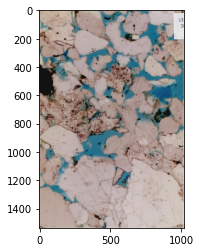

In [8]:
plt.imshow(X_dataA[1,:,:,:])

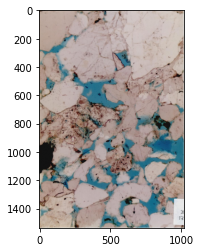

In [9]:
plt.imshow(np.flip(X_dataA,axis=1)[1,:,:,:])

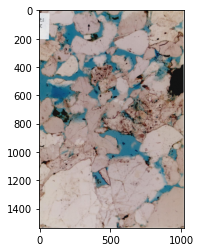

In [10]:
plt.imshow(np.flip(X_dataA,axis=2)[1,:,:,:])

In [11]:
X_dataA=np.concatenate((X_dataA,np.flip(X_dataA,axis=1),np.flip(X_dataA,axis=2)),axis=0)
y_dataA=np.concatenate((y_dataA,y_dataA,y_dataA),axis=0)
print(X_dataA.shape)
print(y_dataA.shape)

(456, 1536, 1024, 3)
(456,)


In [12]:
def plot_thin_section(item):
    
    fig, ax = plt.subplots(figsize=(5, 5),frameon=False)
    
    ax.title.set_text('Porosity # '+str(round(y_dataA[item],2)))
    ax.imshow(X_dataA[item,:,:,:])

In [13]:
sliders_item = widgets.IntSlider(min=0, max=X_dataA.shape[0], step=1, value=0, description='Item # ')
interact(plot_thin_section, item=sliders_item)

interactive(children=(IntSlider(value=0, description='Item # ', max=456), Output()), _dom_classes=('widget-int…

<function __main__.plot_thin_section(item)>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_dataA, y_dataA, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(410, 1536, 1024, 3)
(46, 1536, 1024, 3)
(410,)
(46,)


In [93]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, stride=(2,2), batchnorm=True):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # add downsampling layer
    g = Conv2D(n_filters, (2,2), strides=stride, padding='same', kernel_initializer=init)(layer_in)
    
    g = MaxPooling2D()(g)
    
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    
    
    # leaky relu activation
    #g = LeakyReLU(alpha=0.2)(g)
    g = Activation('relu')(g)
    
    return g
 
    
def side_branch(x, factor):
    x = Conv2D(1, (1, 1), activation=None, padding='same')(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(1, kernel_size, strides=factor, padding='same', use_bias=False, activation=None)(x)

    return x
 
    
# define the standalone generator model
def define_generator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # image input
    in_image = Input(shape=image_shape)
    
    # encoder model
    e1 = define_encoder_block(in_image, 64, stride=(3,2), batchnorm=False)
    b1= side_branch(e1, 1) # 480 480 1
    e2 = define_encoder_block(e1, 128)
    b2= side_branch(e2, 4) # 480 480 1
    e3 = define_encoder_block(e2, 256)
    b3= side_branch(e3, 16) # 480 480 1
    e4 = define_encoder_block(e3, 512)
    b4= side_branch(e4, 64) # 480 480 1
    #e5 = define_encoder_block(e4, 512)
    #e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    
    fuse = Concatenate(axis=-1)([b1, b2, b3, b4])
    
    #fuse = Conv2D(1, (1,1), padding='same', use_bias=False, activation=None)(fuse)
    
    # bottleneck, no batch norm and relu
    #b = Conv2D(1, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(fuse)
    #b = Activation('relu')(b)
    
    x = Flatten()(fuse)
    #x = Dense(1)(x)
    #x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    #x = Dense(64)(x)
    #x = Activation("relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.25)(x)
    
    # check to see if the regression node should be added
    #if regress:
        #x = Dense(1, activation="linear")(x)
    out_image = Dense(1, activation="sigmoid")(x)

    # define model
    model = Model(in_image, out_image)
    
    return model

In [94]:
keras.backend.clear_session()
# define input shape based on the loaded dataset
image_shape = X_train[0].shape

g_model = define_generator(image_shape)

# compile model
opt = Adam(lr=0.001, beta_1=0.5)

g_model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse']) #, 'mae', 'mean_absolute_percentage_error'

In [95]:
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1536, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [96]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
filepath = "ThinSectionAE-model-{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

history = g_model.fit(X_train, y_train,
          epochs=100,
          batch_size=8,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[es, checkpoint])

Train on 410 samples, validate on 46 samples
Epoch 1/100
410/410 [==============================] - 77s 188ms/step - loss: 107.7245 - mse: 0.2123 - val_loss: 98.0494 - val_mse: 0.1854

Epoch 00001: val_loss improved from inf to 98.04945, saving model to ThinSectionAE-model-01-107.7245-98.0494.hdf5
Epoch 2/100
410/410 [==============================] - 71s 173ms/step - loss: 109.1980 - mse: 0.2289 - val_loss: 175.3606 - val_mse: 0.3275

Epoch 00002: val_loss did not improve from 98.04945
Epoch 3/100
410/410 [==============================] - 73s 177ms/step - loss: 155.0808 - mse: 0.3262 - val_loss: 188.5957 - val_mse: 0.3587

Epoch 00003: val_loss did not improve from 98.04945
Epoch 4/100
410/410 [==============================] - 72s 175ms/step - loss: 147.0639 - mse: 0.3084 - val_loss: 197.7425 - val_mse: 0.3658

Epoch 00004: val_loss did not improve from 98.04945
Epoch 5/100
410/410 [==============================] - 70s 171ms/step - loss: 132.6132 - mse: 0.2793 - val_loss: 147.6818 

KeyboardInterrupt: 

In [32]:
#https://github.com/lc82111/Keras_HED


def hed():
    # Input
    img_input = Input(shape=(1536, 1024,3), name='input')

    # Block 1
    x = Conv2D(64, (3, 3), strides=(3,2), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    b1= side_branch(x, 1) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x) # 240 240 64

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    b2= side_branch(x, 2) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool')(x) # 120 120 128

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    b3= side_branch(x, 4) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool')(x) # 60 60 256

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    b4= side_branch(x, 8) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool')(x) # 30 30 512

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x) # 30 30 512
    b5= side_branch(x, 16) # 480 480 1

    # fuse
    fuse = Concatenate(axis=-1)([b1, b2, b3, b4, b5])

    fuse = Conv2D(1, (1,1), padding='same', use_bias=False, activation=None)(fuse) # 480 480 1


    x = Flatten()(fuse)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # model
    
    #filepath = '/home/congliu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    #load_weights_from_hdf5_group_by_name(model, filepath)
    
    out_image = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[img_input], outputs=out_image)
    
    opt = Adam(lr=0.001)

    model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse'])

    return model

### Tuning Learning rate

In [91]:
keras.backend.clear_session()

In [ ]:
epochs = np.array(range(10))
x= 1e-8 * 10**(epochs)
plt.semilogy(epochs,x)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch))

history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[lr_scheduler])

In [ ]:
# train the model
print("[INFO] training model...")
model.fit(X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=200, batch_size=8)

In [ ]:
g_model.summary()

In [ ]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

In [ ]:
keras.backend.clear_session()
# define input shape based on the loaded dataset
image_shape = X_train[0].shape

g_model = define_generator(image_shape)

# compile model
opt = Adam(lr=0.001, beta_1=0.5)

g_model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse']) #, 'mae', 'mean_absolute_percentage_error'

In [ ]:
g_model.summary()

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch))

history = g_model.fit(X_train, y_train,
          epochs=10,
          batch_size=8,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[lr_scheduler])

In [ ]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

In [ ]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

In [ ]:
ls

In [ ]:
X_test_predict.shape

In [ ]:
from sklearn.linear_model import LinearRegression
model = load_model('ThinSectionAE-model-32-23.8211-23.3568.hdf5') #max pooling added, lr -.001, filter (2,2), mpe, batch size 8
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:

from sklearn.linear_model import LinearRegression
model = load_model('ThinSectionAE-model-32-23.8211-23.3568.hdf5') #max pooling added, lr -.001, filter (2,2), mpe
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:

from sklearn.linear_model import LinearRegression
model = load_model('ThinSectionAE-model-39-0.0085-0.0134.hdf5') #max pooling added, lr -.001, filter (2,2), x = Dense(512*2)(x)
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
from sklearn.linear_model import LinearRegression
model = load_model('ThinSectionAE-model-27-0.0149-0.0132.hdf5') #max pooling added, lr -.001, filter (2,2)
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
from sklearn.linear_model import LinearRegression
model = load_model('ThinSectionAE-model-22-0.0153-0.0113.hdf5') #max pooling added, lr -.001
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
from sklearn.linear_model import LinearRegression
model = load_model('ThinSectionAE-model-39-0.0284-0.0166.hdf5') #max pooling added
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
model = load_model('ThinSectionAE-model-22-0.1565-0.1254.hdf5') #3x3 filters, mae loss
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:

model = load_model('ThinSectionAE-model-24-0.0272-0.0248.hdf5') #5x5 filters
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
model = load_model('ThinSectionAE-model-23-0.0271-0.0202.hdf5') #3x3 filters
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
model = load_model('ThinSectionAE-model-44-0.0066-0.0207.hdf5') 
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

In [ ]:
model = load_model('ThinSectionAE-model-21-0.0163-0.0283.hdf5') 
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)